<a href="https://colab.research.google.com/github/aqilahassan-hub/Multi-domain-Endoscopic-Surgeon-Action-Detection/blob/main/yolo%20to%20coco%20v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import torch
from IPython.display import Image  # for displaying images
import os, zipfile
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

import logging
logging.getLogger().setLevel(logging.CRITICAL)
!pip install pylabel > /dev/null

#!pip install pylabel

from pylabel import importer
from pylabel import *

from pathlib import PurePath

import yaml

In [27]:
!cat "/content/drive/MyDrive/Custom Data/Labels/Validation/real3_frame_105.txt"

14 0.73515625 0.35208333333333336 0.4921875 0.42916666666666664
16 0.7703125 0.8916666666666667 0.553125 0.5083333333333333

In [28]:
!cat "/content/drive/MyDrive/Custom Data/mesad.yaml"

# Training and Validation data paths
train: /content/drive/MyDrive/Custom Data/Images/Training


# Number of Classes
nc: 21

# Class Names
names: [ "CuttingThread", "PullingVasDeferens", "PullingSeminalVesicle", "CuttingSeminalVesicle", 
         "ClippingBladderNeck", "SuckingSmoke", "SuckingBlood", "PullingProstate", "CuttingProstate", 
         "BaggingProstate", "CuttingTissue", "BladderNeckDissection", "ClippingSeminalVesicle", 
         "ClippingVasDeferens", "CuttingMesocolon", "CuttingVasDeferens", "PullingTissue", "BladderAnastomosis", 
         "ClippingTissue", "PullingBladderNeck", "UrethraDissection"]


In [31]:
data0 = importer.ImportYoloV5WithYaml(yaml_file="/content/drive/MyDrive/Custom Data/mesad.yaml", 
                     path_to_annotations="/content/drive/MyDrive/Custom Data/Labels/Validation", 
                     image_ext='jpg',
                      name_of_annotations_folder="annotations")

In [32]:
#An example of what the data looks like
data0.df.head(5)

,img_folder,img_filename,img_path,img_id,img_width,img_height,img_depth,ann_segmented,ann_bbox_xmin,ann_bbox_ymin,...,ann_segmentation,ann_iscrowd,ann_pose,ann_truncated,ann_difficult,cat_id,cat_name,cat_supercategory,split,annotated
id,,,,,,,,,,,,,,,,,,,,,
0,/content/drive/MyDrive/Custom Data/Images/Vali...,real3_frame_183.jpg,,0,720,576,3,,78.750,278.4,...,,,,,,16,PullingTissue,,train,1
1,/content/drive/MyDrive/Custom Data/Images/Vali...,real3_frame_183.jpg,,0,720,576,3,,281.250,184.8,...,,,,,,14,CuttingMesocolon,,train,1
2,/content/drive/MyDrive/Custom Data/Images/Vali...,real3_frame_264.jpg,,1,720,576,3,,175.500,211.2,...,,,,,,16,PullingTissue,,train,1
3,/content/drive/MyDrive/Custom Data/Images/Vali...,real3_frame_264.jpg,,1,720,576,3,,172.125,25.2,...,,,,,,14,CuttingMesocolon,,train,1
4,/content/drive/MyDrive/Custom Data/Images/Vali...,real3_frame_178.jpg,,2,720,576,3,,97.875,283.2,...,,,,,,16,PullingTissue,,train,1


In [33]:
from pylabel import importer

In [34]:
path_to_annotations = "/content/drive/MyDrive/Custom Data/Labels/Validation/"

#Identify the path to get from the annotations to the images 
path_to_images = "/content/drive/MyDrive/Custom Data/Images/Validation/"

#Import the dataset into the pylable schema 
#Class names are defined here https://github.com/ultralytics/yolov5/blob/master/data/coco128.yaml
yoloclasses = [ "CuttingThread", "PullingVasDeferens", "PullingSeminalVesicle", "CuttingSeminalVesicle", 
         "ClippingBladderNeck", "SuckingSmoke", "SuckingBlood", "PullingProstate", "CuttingProstate", 
         "BaggingProstate", "CuttingTissue", "BladderNeckDissection", "ClippingSeminalVesicle", 
         "ClippingVasDeferens", "CuttingMesocolon", "CuttingVasDeferens", "PullingTissue", "BladderAnastomosis", 
         "ClippingTissue", "PullingBladderNeck", "UrethraDissection"]

dataset = importer.ImportYoloV5(path=path_to_annotations, path_to_images=path_to_images, cat_names=yoloclasses,
    img_ext="jpg", name="coco128")

dataset.df.head(5)

,img_folder,img_filename,img_path,img_id,img_width,img_height,img_depth,ann_segmented,ann_bbox_xmin,ann_bbox_ymin,...,ann_segmentation,ann_iscrowd,ann_pose,ann_truncated,ann_difficult,cat_id,cat_name,cat_supercategory,split,annotated
id,,,,,,,,,,,,,,,,,,,,,
0,/content/drive/MyDrive/Custom Data/Images/Vali...,real3_frame_183.jpg,,0,720,576,3,,78.750,278.4,...,,,,,,16,PullingTissue,,,1
1,/content/drive/MyDrive/Custom Data/Images/Vali...,real3_frame_183.jpg,,0,720,576,3,,281.250,184.8,...,,,,,,14,CuttingMesocolon,,,1
2,/content/drive/MyDrive/Custom Data/Images/Vali...,real3_frame_264.jpg,,1,720,576,3,,175.500,211.2,...,,,,,,16,PullingTissue,,,1
3,/content/drive/MyDrive/Custom Data/Images/Vali...,real3_frame_264.jpg,,1,720,576,3,,172.125,25.2,...,,,,,,14,CuttingMesocolon,,,1
4,/content/drive/MyDrive/Custom Data/Images/Vali...,real3_frame_178.jpg,,2,720,576,3,,97.875,283.2,...,,,,,,16,PullingTissue,,,1


In [35]:
print(f"Number of images: {dataset.analyze.num_images}")
print(f"Number of classes: {dataset.analyze.num_classes}")
print(f"Classes:{dataset.analyze.classes}")
print(f"Class counts:\n{dataset.analyze.class_counts}")

Number of images: 183
Number of classes: 10
Classes:['PullingVasDeferens', 'PullingSeminalVesicle', 'CuttingSeminalVesicle', 'SuckingSmoke', 'SuckingBlood', 'CuttingTissue', 'ClippingVasDeferens', 'CuttingMesocolon', 'CuttingVasDeferens', 'PullingTissue']
Class counts:
PullingTissue            133
CuttingTissue             85
CuttingMesocolon          56
PullingVasDeferens        20
PullingSeminalVesicle     20
CuttingSeminalVesicle     13
SuckingSmoke              12
ClippingVasDeferens        7
SuckingBlood               5
CuttingVasDeferens         5
Name: cat_name, dtype: int64


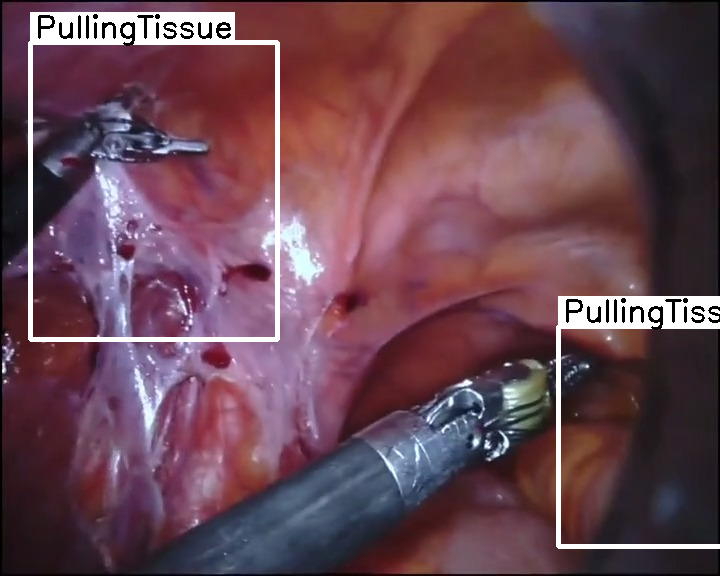

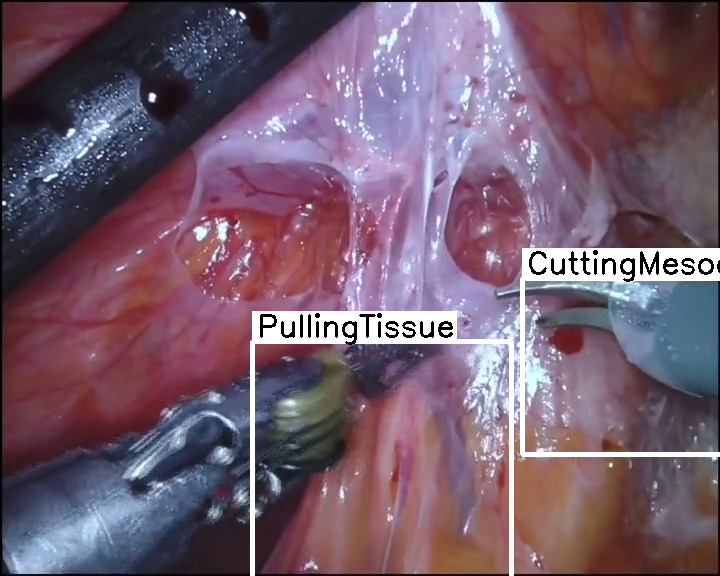

In [25]:
from IPython.display import Image, display
display(dataset.visualize.ShowBoundingBoxes(100))
display(dataset.visualize.ShowBoundingBoxes(30))

In [36]:
dataset.export.ExportToCoco(cat_id_index=1)

['/content/drive/MyDrive/Custom Data/Labels/Validation/coco128.json']